In [1]:
import torch
import numpy as np
import pylab as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport log_plotter
from log_plotter import get_run_names, get_data, get_data_pth, plot_smooth, plot_tag, plot_runs_and_tags, get_legend, plot_smooth_o1

In [5]:
save_single = False
plt.rcParams.update({'font.size': 12})

# Transformer (from before)
- write gluster layer for attention
- write data loader that loads from two streams, uniform and stratified sampled data
- estimate the variance
- compute train loss with uniform sampling
- better to modify transformer-xl code directly without using gvar class

April 22

https://github.com/nyu-mll/jiant/blob/master/tutorials/setup_tutorial.md
* ```jiant/utils/serialize.py:read_records```: return index
* ```jiant/preprocess.py```: pass ```split``` to ```read_records``` to only return index for train_data
* ```jiant/trainer.py```: add lines to update cluster assignments in ```task_info["tr_generator"]```
* 
* write gluster layers in model

* ```allennlp/data/iterators/bucket_iterator.py:_create_batches```: loads at most 10,000 examples in memory at most, but largest batch size is 32, or 20, or 8. We could potentially reuse examples from the loaded batch. So, how about doing an assignment on the entire 10,000, then reuse them a few times.
* max_instances_in_memory=10000 in ```jiant/trainer.py```
* Gluster is fine with linear layers, let's try without any new layers for now
* hooks are fine now, left to do: add gluster assign and update, sample

April 23
* Instead of changing allennlp, I'll add a new class of iterator that modifies the function ```self._memory_sized_lists``` to return gluster batches. This way, I can keep the original iterator intact.
* nope, that's hard, let's modify allennlp
* add index to data (done through metadata field)
* add weighting to the loss and no reduction (this is different for each task)
* **removal of extra stuff in gluster might have introduced bugs**

April 24
* BucketIterator drops the last batch (not true, it only moves it to the front)

April 25
* GG for transformer?
* why is there an extra /T? it matters, it will bias gluster to smaller layers

```
ck dkt = 1/n sum_b (Ab Dbt)
ass. 1/n sum_b,b’ Ab Db’t = 0, b!=b’

ck dkt = (1/n sum_b ab) (1/n sum_b db)t
until now:
= 1/n2 (sum_b!=b’ ab db’t + sum_b ab dbt)
= 1/n2 (sum_b ab (
missing sqrt(n), should be
1/n sum_b ab dbt

ck dkt = 1/n sum_b (sum_t Ab Dbt)
until now:
ck dkt = (1/Tn sum_b sum_t ab) (1/n sum_b sum_t db)t
= 1/Tn2 (sum_b!=b’ (sum_t ab) (sum_t db’t) + sum_b (sum_t abt) (sum_t dbt)t)
ass. sum_b!=b’ (sum_t ab) (sum_t db’t) = 0 (activations and output derives of different point are indep)

= 1/Tn2 (sum_b sum_t!=t abt dbt't + sum_b sum_t abt dbtt)
ass. sum_t!=t' abt dbt't = 0 (activations and derives in one image across spatial locs are indep)

= 1/Tn2 (sum_b sum_t abt dbtt)
Tn2 should be n

both ass. are implied by teh IAD assumption in kfac-conv where it says ajt indep of dit'
the challenges is when we have aa or dd terms, that happens in GG

GG:
vec(sum_t abt dbtt) dot vec(sum_t abt dbtt)
= sum_u,v (sum_t abtu dbtvT) (sum_t abtu dbtvT)
(this is the correct thing and it is always chosen in resnet because t is usually large and u,v small)

extra division by T in kfac-conv appears in E Ds Ds that we don't have, we don't have second order terms
```

```
indep (px,y=pxpy)
uncorr (cov(x,y)=0, Exy = ExEy):
E A D = EA ED
1/n sum_b A D = (1/n sum_b A) (1/n sum_b D)

1/n sum_b sum_t A D = (1/n sum_b sum_t A) (1/n sum_b sum_t D)

spatial uncorr ass.:
E_t A D = E_t A E_t D
1/T sum_t A D = 1/T sum_t A 1/T sum_t D
sum_t A D = 1/T sum_t A sum_t D

E_tb A D = E_tb A E_tb D
1/T 1/n sum_b sum_t A D = 1/T 1/n sum_b sum_t A 1/n 1/T sum_b sum_t D
1/n sum_b sum_t A D = 1/T (1/n sum_b sum_t A) (1/n sum_b sum_t D)
```

the above are only used in factorization step, computing the distance makes no assumptions

why does total distortion explode?

Apr 28
* cluster size in batch assignment is wrong initialized (better this way, total dist over iterations will be more meaningful bc the cluster size is updated for the current assignments as opposed to lagging which would cause the total dist to show inaccurate going up, also assignments will be hurt)
* pairwise

TODO:
* svrg
* online
* transformer layer
* other layers? eg conv
* test uncorr assumptions empirically
* save gluster to resume

# SST (first run)

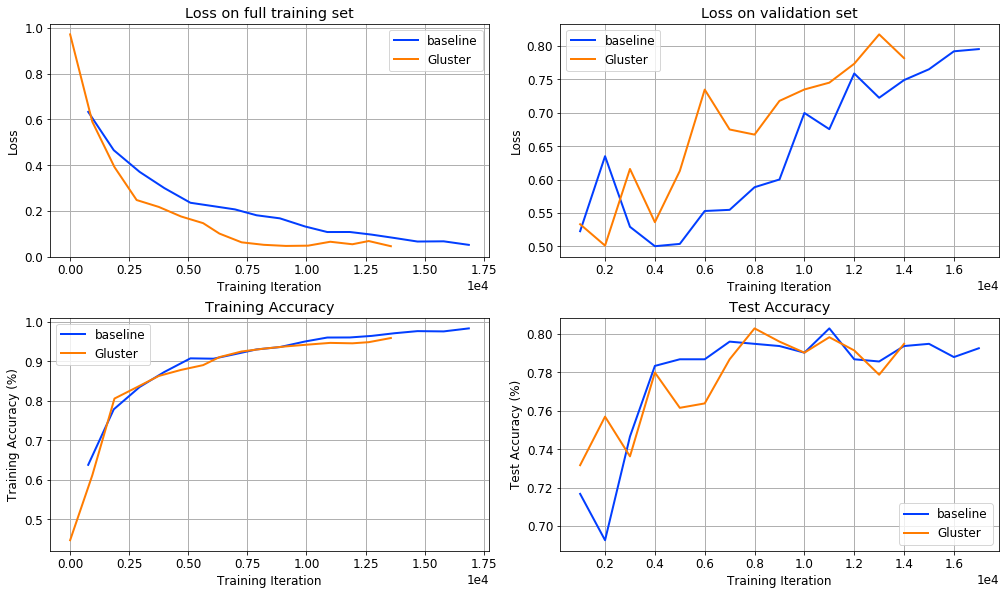

In [11]:
get_data_f = get_data_pth
plot_f = plt.plot
# plot_f = plot_smooth_o1
logdir = '/u/faghri/dmom/jiant/my_exp/'
patterns = ['.*my_exp/sst_(baseline|gluster)$']  # (?!.*scheduler)
tag_names = ['Tsst/sst_loss', 'Vsst/sst_loss', 'Tsst/sst_accuracy', 'Vsst/sst_accuracy']
fig_name = 'figs_nlp/sst.png'
lg_tags = ['baseline', 'gluster']  # g_estim
ylim = [None]*20
# ylim = [None, [0, 2e-5], None, None, None, None]
# ylim = [[1e-4, 1e-1], [1e-2, 1e-1], [98, 100], [97,100], [0, 100], None, None, None, None, None, None, None, None, None, None, None, None]
sep_h = True
ncolor = 5
no_title = False
lg_replace = [('estim_sgd', 'sgd'), (' ', ','), ('g_nclusters_', 'C='), ('sgd', 'SGD'), ('svrg', 'SVRG'), ('gluster', 'Gluster'), ('g_osnap_iter_', 'Oi='), ('g_beta_', 'beta='), ('g_min_size_', 'sz='), ('duplicate_10', 'Dup'), ('batch_size_', 'B='), (',B=128', '')]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim, sep_h=sep_h, ncolor=ncolor, lg_replace=lg_replace, save_single=save_single, no_title=no_title)

* gluster has quickly overfitted to sst
* early stopping criteria prevents gluster to continue overfitting

- PairClassificationTask: mrpc, qqp, mnli, qnli, rte, wnli, glue-diagnostic
- SingleClassificationTask: sst,cola
- PairRegressionTask: sts-b

order of size: wnli,cola,sts-b,mrpc,rte,sst,qnli,qqp,mnli

TODO:
* n train (fixed)
* multitask
* svrg
* online
* transformer layer
* other layers? eg conv
* test uncorr assumptions empirically
* save gluster to resume

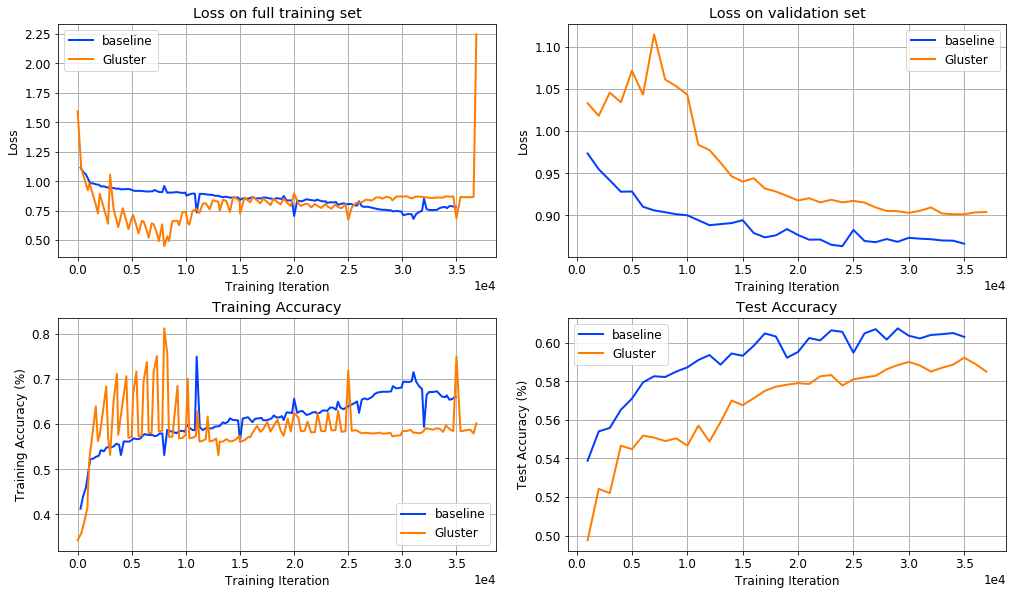

In [17]:
get_data_f = get_data_pth
plot_f = plt.plot
# plot_f = plot_smooth_o1
logdir = '/u/faghri/dmom/jiant/my_exp/'
patterns = ['.*my_exp/mnli_(baseline|gluster)$']  # (?!.*scheduler)
tag_names = ['Tmnli/mnli_loss', 'Vmnli/mnli_loss', 'Tmnli/mnli_accuracy', 'Vmnli/mnli_accuracy']
fig_name = 'figs_nlp/mnli.png'
lg_tags = ['baseline', 'gluster']  # g_estim
ylim = [None]*20
# ylim = [None, [0, 2e-5], None, None, None, None]
# ylim = [[1e-4, 1e-1], [1e-2, 1e-1], [98, 100], [97,100], [0, 100], None, None, None, None, None, None, None, None, None, None, None, None]
sep_h = True
ncolor = 5
no_title = False
lg_replace = [('estim_sgd', 'sgd'), (' ', ','), ('g_nclusters_', 'C='), ('sgd', 'SGD'), ('svrg', 'SVRG'), ('gluster', 'Gluster'), ('g_osnap_iter_', 'Oi='), ('g_beta_', 'beta='), ('g_min_size_', 'sz='), ('duplicate_10', 'Dup'), ('batch_size_', 'B='), (',B=128', '')]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim, sep_h=sep_h, ncolor=ncolor, lg_replace=lg_replace, save_single=save_single, no_title=no_title)

* https://arxiv.org/pdf/1812.10860.pdf
* https://github.com/nyu-mll/jiant/blob/master/jiant/config/defaults.conf

David (May 1)
* effective sample size in particle filtering
* var of loss is not lower if the var of gradients are lower
* confidence bounds in the loss?
* measure the variance in the loss numerically
* gluster can be worse in variance of the loss

# Val on train

* Gluster's loss is not the same as true train loss, why?
* maybe because of sample reuse?

* no, not the reuse

* try nclusters=batch size
* random assignments gives unbiased loss

* nclusters=16 has more bias in the loss
* maybe the problem is it is overfitting to the current portion of data

* this means samples are uniformly sampled

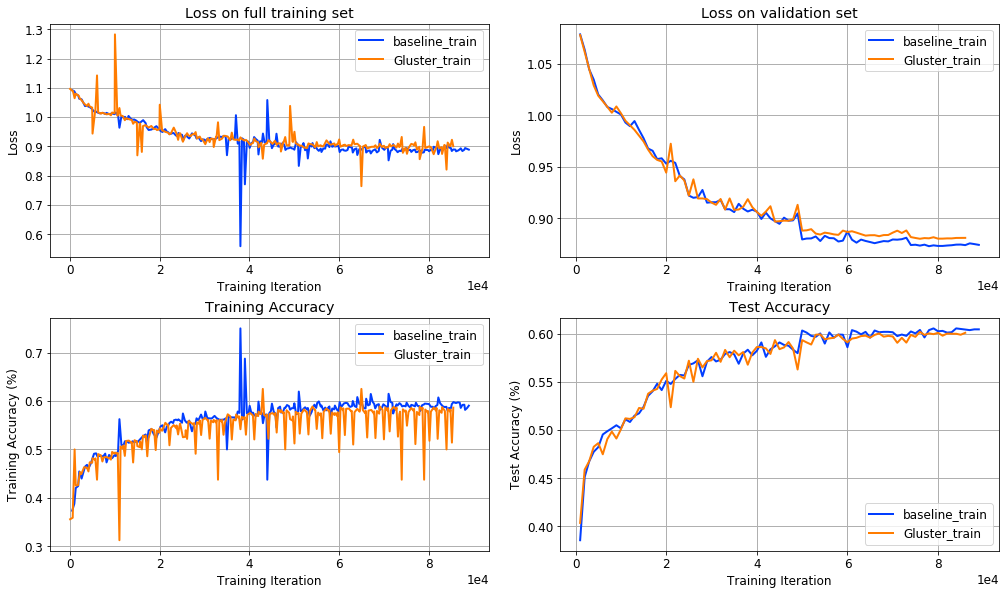

In [77]:
get_data_f = get_data_pth
plot_f = plt.plot
dataset = 'mnli'
# plot_f = plot_smooth_o1
logdir = '/u/faghri/dmom/jiant/my_exp/'
patterns = ['.*my_exp/%s_(baseline|gluster)_train$' % dataset]  # (?!.*scheduler)
tag_names = ['TDATA/DATA_loss', 'VDATA/DATA_loss', 'TDATA/DATA_accuracy', 'VDATA/DATA_accuracy']
tag_names = [tg.replace('DATA', dataset) for tg in tag_names]
fig_name = 'figs_nlp/%s_train.png' % dataset
lg_tags = ['baseline', 'gluster']  # g_estim
ylim = [None]*20
# ylim = [None, [0, 2e-5], None, None, None, None]
# ylim = [[1e-4, 1e-1], [1e-2, 1e-1], [98, 100], [97,100], [0, 100], None, None, None, None, None, None, None, None, None, None, None, None]
sep_h = True
ncolor = 5
no_title = False
lg_replace = [('estim_sgd', 'sgd'), (' ', ','), ('g_nclusters_', 'C='), ('sgd', 'SGD'), ('svrg', 'SVRG'), ('gluster', 'Gluster'), ('g_osnap_iter_', 'Oi='), ('g_beta_', 'beta='), ('g_min_size_', 'sz='), ('duplicate_10', 'Dup'), ('batch_size_', 'B='), (',B=128', '')]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim, sep_h=sep_h, ncolor=ncolor, lg_replace=lg_replace, save_single=save_single, no_title=no_title)

* training accuracy measured in train_accuracy doesn't matter because it doesn't have the reweighting. See Test loss and accuracy.
* train loss is about the same as sgd in mini-batch loss but the training continuned without learning rate drop ond gluster progressed in improving the true training loss and accuracy

* total distortions doesn't go down much and the loss is about the same
* let's focus on total distortion

```for TASK in wnli cola sts-b mrpc rte sst qnli qqp mnli; do echo $TASK; grep 'total distortions' gluster_totdist_$TASK/log.log ; done```

* wnli, mrpc, rte mismatch dim error

* qnli, qqp total dist is decreasing, a little mnli

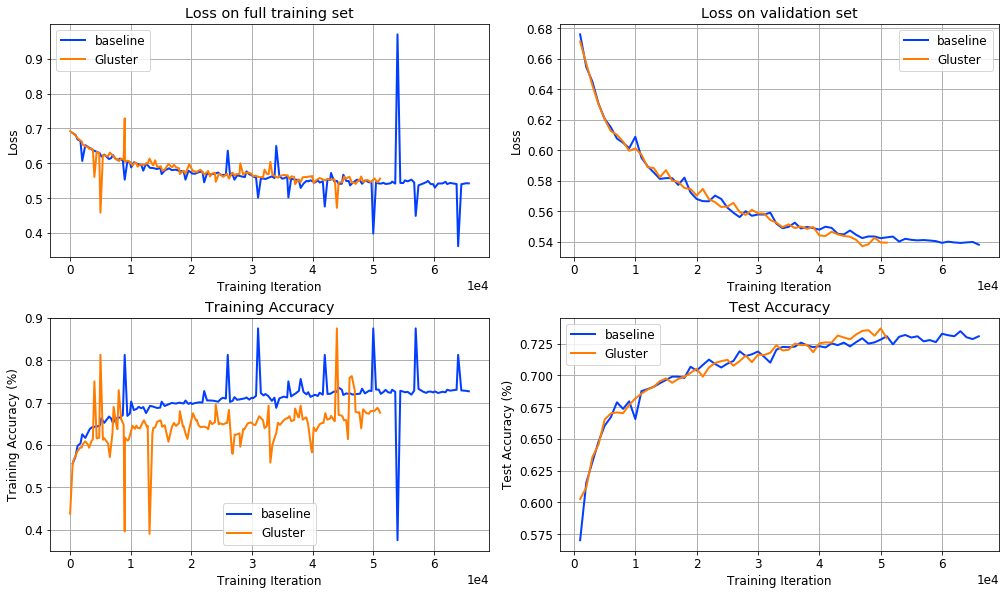

In [81]:
get_data_f = get_data_pth
plot_f = plt.plot
dataset = 'qnli'
# plot_f = plot_smooth_o1
logdir = '/u/faghri/dmom/jiant/my_exp/'
patterns = ['.*my_exp/%s_(baseline|gluster)$' % dataset]  # (?!.*scheduler)
tag_names = ['TDATA/DATA_loss', 'VDATA/DATA_loss', 'TDATA/DATA_accuracy', 'VDATA/DATA_accuracy']
tag_names = [tg.replace('DATA', dataset) for tg in tag_names]
fig_name = 'figs_nlp/%s.png' % dataset
lg_tags = ['baseline', 'gluster']  # g_estim
ylim = [None]*20
# ylim = [None, [0, 2e-5], None, None, None, None]
# ylim = [[1e-4, 1e-1], [1e-2, 1e-1], [98, 100], [97,100], [0, 100], None, None, None, None, None, None, None, None, None, None, None, None]
sep_h = True
ncolor = 5
no_title = False
lg_replace = [('estim_sgd', 'sgd'), (' ', ','), ('g_nclusters_', 'C='), ('sgd', 'SGD'), ('svrg', 'SVRG'), ('gluster', 'Gluster'), ('g_osnap_iter_', 'Oi='), ('g_beta_', 'beta='), ('g_min_size_', 'sz='), ('duplicate_10', 'Dup'), ('batch_size_', 'B='), (',B=128', '')]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim, sep_h=sep_h, ncolor=ncolor, lg_replace=lg_replace, save_single=save_single, no_title=no_title)

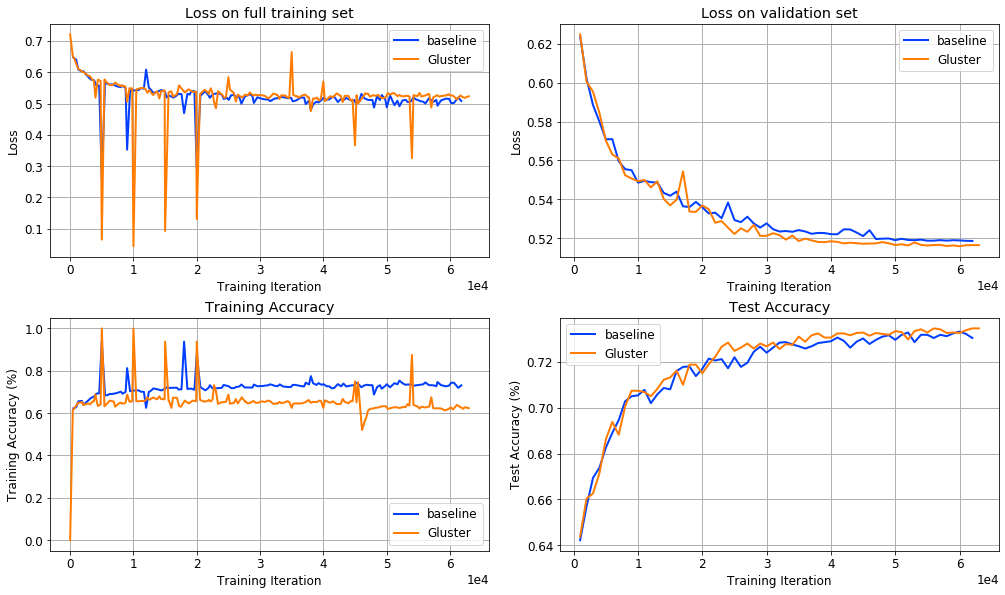

In [83]:
get_data_f = get_data_pth
plot_f = plt.plot
dataset = 'qqp'
# plot_f = plot_smooth_o1
logdir = '/u/faghri/dmom/jiant/my_exp/'
patterns = ['.*my_exp/%s_(baseline|gluster)$' % dataset]  # (?!.*scheduler)
tag_names = ['TDATA/DATA_loss', 'VDATA/DATA_loss', 'TDATA/DATA_accuracy', 'VDATA/DATA_accuracy']
tag_names = [tg.replace('DATA', dataset) for tg in tag_names]
fig_name = 'figs_nlp/%s.png' % dataset
lg_tags = ['baseline', 'gluster']  # g_estim
ylim = [None]*20
# ylim = [None, [0, 2e-5], None, None, None, None]
# ylim = [[1e-4, 1e-1], [1e-2, 1e-1], [98, 100], [97,100], [0, 100], None, None, None, None, None, None, None, None, None, None, None, None]
sep_h = True
ncolor = 5
no_title = False
lg_replace = [('estim_sgd', 'sgd'), (' ', ','), ('g_nclusters_', 'C='), ('sgd', 'SGD'), ('svrg', 'SVRG'), ('gluster', 'Gluster'), ('g_osnap_iter_', 'Oi='), ('g_beta_', 'beta='), ('g_min_size_', 'sz='), ('duplicate_10', 'Dup'), ('batch_size_', 'B='), (',B=128', '')]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim, sep_h=sep_h, ncolor=ncolor, lg_replace=lg_replace, save_single=save_single, no_title=no_title)

maybe because batch size is very small and cluster size has to be small

```TASK=copa; CUDA_VISIBLE_DEVICES=2 ipython --pdb -- main.py --config_file jiant/config/baseline.conf --overrides "run_name = "$TASK"_bert_baseline, pretrain_tasks = $TASK, target_tasks = $TASK"```


```TASK=copa; CUDA_VISIBLE_DEVICES=1 ipython --pdb -- main.py --config_file jiant/config/gluster.conf --overrides "run_name = "$TASK"_bert_gluster, pretrain_tasks = $TASK, target_tasks = $TASK, val_on_train = True, gb_citers = 3, g_buffer_repeat = 1, g_nclusters = 16"```

* activation mismatch with bert, the error from multiple tasks

```allennlp/data/iterators/bucket_iterator.py```